In [26]:
import jax
from jax import random
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr
import blackjax
import tinygp
from tensorflow_probability.substrates import jax as tfp

from print_versions import print_versions
print_versions(globals())

import time
import matplotlib.pyplot as plt
import tqdm

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Config and Info
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f'NUM_CPU_CORES: {num_cores}')

import sys
sys.path.append('../') # Make main module visible

jnp.array(1.) # Check that jax works
print(jax.devices())

SKIP_TESTS = False

jax==0.4.27
blackjax==1.2.3
tinygp==0.3.0
tensorflow_probability.substrates.jax==0.24.0
tqdm==4.66.5
matplotlib==3.9.2
numpy==1.26.4
scipy==1.14.1
NUM_CPU_CORES: 6
[CpuDevice(id=0)]


In [27]:

def get_test_dataset():
    import numpy as np
    random = np.random.default_rng(42)

    x = np.sort(
        np.append(
            random.uniform(0, 3.8, 28),
            random.uniform(5.5, 10, 18),
        )
    )
    yerr = random.uniform(0.08, 0.22, len(x))
    y = (
        0.2 * (x - 5)
        + np.sin(3 * x + 0.1 * (x - 5) ** 2)
        + yerr * random.normal(size=len(x))
    )

    true_x = np.linspace(0, 10, 100)
    true_y = 0.2 * (true_x - 5) + np.sin(3 * true_x + 0.1 * (true_x - 5) ** 2)
    return x, y, yerr, true_x, true_y

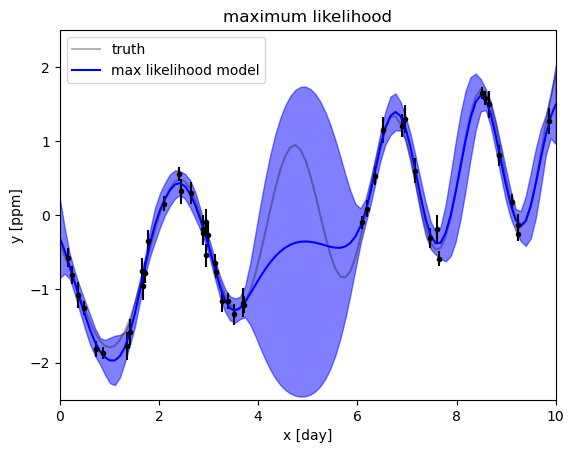

In [28]:
from bbs.gaussian_process import train_gp_params, default_build_gp

def TEST_GP():
    x, y, yerr, true_x, true_y = get_test_dataset()
    build_gp = default_build_gp
    init_params = {
        'log_gp_amp': jnp.log(0.1),
        'log_gp_scale': jnp.log(1),
        'gp_mean': jnp.float64(0.0),
        'log_gp_diag': jnp.log(0.1),
    }

    key = jr.PRNGKey(123)
    params = train_gp_params(None, init_params, x, y, build_gp)

    pred, var = build_gp(params, x).predict(y, true_x, return_var=True)
    
    interval = 2 * jnp.sqrt(var)

    plt.plot(true_x, true_y, "k", lw=1.5, alpha=0.3, label="truth")
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(true_x, pred, color='b', label="max likelihood model")
    plt.fill_between(true_x, pred-interval, pred+interval, color='b', alpha=0.5)
    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    plt.legend()
    _ = plt.title("maximum likelihood")
if not SKIP_TESTS: TEST_GP()

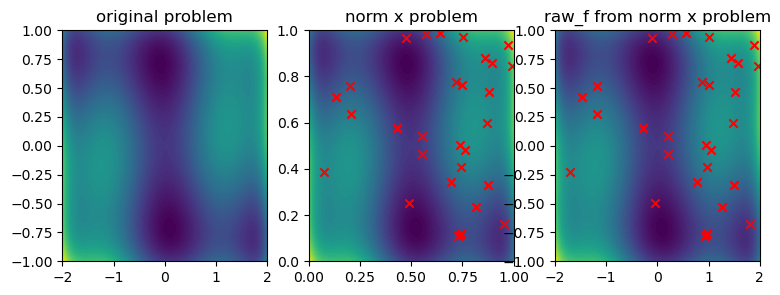

In [29]:
from bbs.datasets import get_problem
import numpy as np

def TEST_PROBLEM():
    def plot_2d_f(f, bounds, n_contour=100, ax=None):
        assert(bounds.shape[0] == 2)

        num_ln = 60
        lnx1 = jnp.linspace(bounds[0,0], bounds[0,1], num_ln)
        lnx2 = jnp.linspace(bounds[1,0], bounds[1,1], num_ln)
        X1, X2 = jnp.meshgrid(lnx1, lnx2)
        xtest = jnp.hstack((X1.reshape(num_ln**2,1),X2.reshape(num_ln**2,1)))
        ytest = f(xtest)

        if ax is None:
            fig, ax = plt.subplots(1, 1)
        ax.set_title('f(x)')
        ax.contourf(X1, X2, ytest.reshape(X1.shape), n_contour)
        return ax



    f, axes = plt.subplots(1,3, figsize=(3*3,1*3))

    x_norm = jr.uniform(jr.PRNGKey(333), shape=(30,2))

    orig_problem = get_problem('sixhumpcamel', normalize_x=False)
    ax = plot_2d_f(orig_problem.f, orig_problem.bounds, ax=axes[0])
    ax.set_title('original problem')
    del ax

    norm_problem = get_problem('sixhumpcamel', normalize_x=True)
    ax = plot_2d_f(norm_problem.f, norm_problem.bounds, ax=axes[1])
    ax.set_title('norm x problem')
    ax.scatter(x_norm[:,0], x_norm[:,1], color='r', marker='x')
    del ax

    ax = plot_2d_f(norm_problem.raw_f, norm_problem.raw_bounds, ax=axes[2])
    ax.set_title('raw_f from norm x problem')
    x_unorm = norm_problem.unorm_fn(x_norm)
    ax.scatter(x_unorm[:,0], x_unorm[:,1], color='r', marker='x')
if not SKIP_TESTS: TEST_PROBLEM()



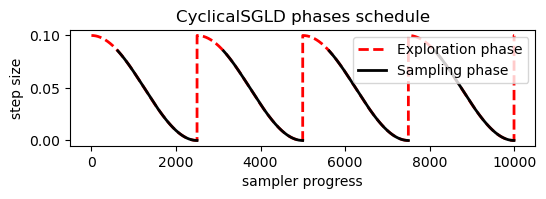

In [30]:
def TEST_CYCLICAL_SCHEDULER():
    from bbs.samplers import build_schedule
    import numpy as np

    n_steps = 10000-1
    schedule_fn = build_schedule(n_steps, 4, 1e-1)
    schedule = [schedule_fn(i) for i in range(n_steps)]

    step_sizes = np.array([step.step_size for step in schedule])
    do_sample = np.array([step.do_sample for step in schedule])

    sampling_points = np.ma.masked_where(~do_sample, step_sizes)

    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.plot(step_sizes, lw=2, ls="--", color="r", label="Exploration phase")
    ax.plot(sampling_points, lw=2, ls="-", color="k", label="Sampling phase")

    ax.set_xlabel("sampler progress")
    ax.set_ylabel("step size")
    plt.legend()
    plt.title("CyclicalSGLD phases schedule")
    fig.savefig('cyclical_sgld.pdf', bbox_inches='tight')

if not SKIP_TESTS: TEST_CYCLICAL_SCHEDULER()

Soft bounds is within x interval (0.989, 1.0579999999999936) and border width 0.06899999999999362 (estimated with eps=0.001)


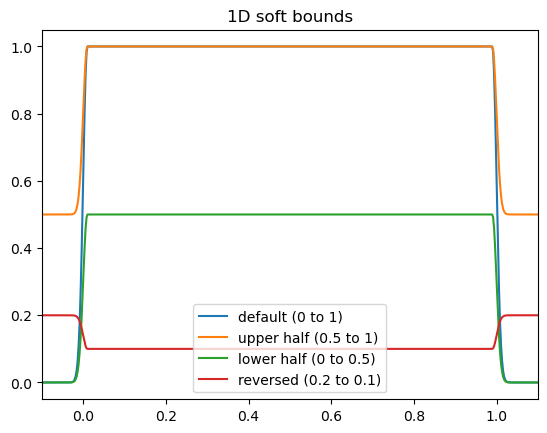

1d value at border 0.6065306597126329


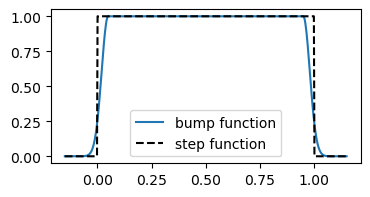

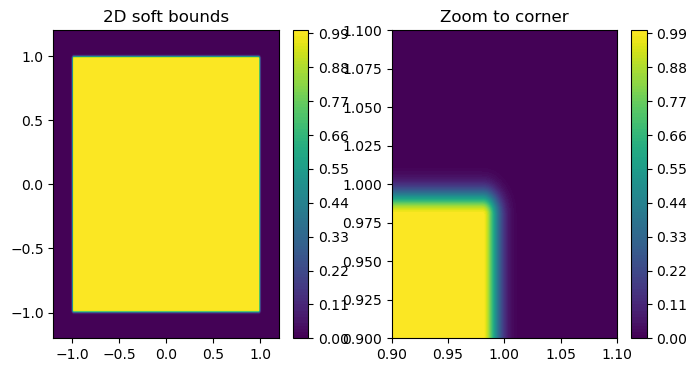

2d value at border 0.1353352832366122
2d value at corner 0.018315638888734047


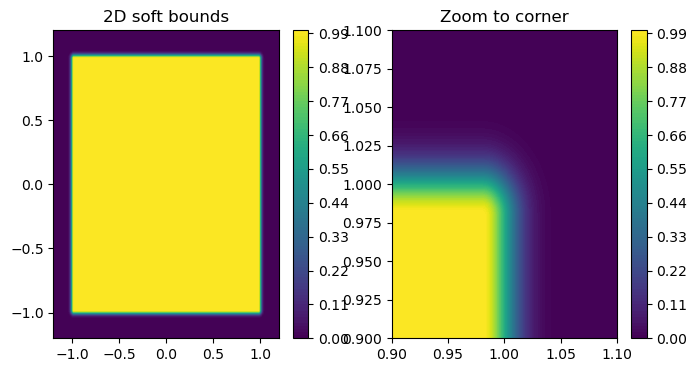

2d value at border 0.6065306597126329
2d value at corner 0.36787944117144167


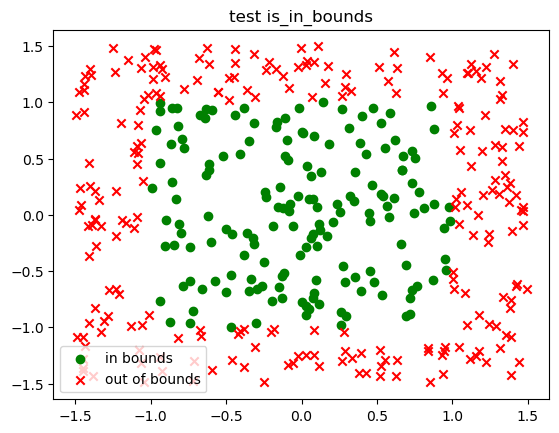

In [31]:
from bbs.utils import soft_bounds_weighting
from bbs.utils import is_in_bounds
import numpy as np

def simple_2d_plot(ax, func, bounds, side_resolution=60, levels=60):
    X1 = np.linspace(bounds[0][0], bounds[0][1], side_resolution)
    X2 = np.linspace(bounds[1][0], bounds[1][1], side_resolution)
    x1, x2 = np.meshgrid(X1, X2)
    X = np.hstack((x1.reshape(side_resolution**2,1),x2.reshape(side_resolution**2,1)))
    vals = func(X)  
    vals_reshaped = np.reshape(vals, (side_resolution, side_resolution))
    ax.contourf(X1, X2, vals_reshaped, levels)

def TEST_1D():
    lin_x = jnp.linspace(-0.1, 1.1, 500).reshape(-1,1)

    bounds_1d = jnp.array([[0,1]])

    soft_bound_1d = lambda x: soft_bounds_weighting(jnp.array([x]), bounds_1d)

    # Test that values are within min and max values and that values are symmetric
    weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0.0, 1.0)
    assert(jnp.max(weighted_x) <= 1.0)
    assert(jnp.min(weighted_x) >= 0.0)
    assert(soft_bound_1d(0.0) - soft_bound_1d(1.0) < 1e-20)

    # Test that changuing the min val doesnt affect the max value
    weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0.5, 1.0)
    assert(jnp.max(weighted_x) <= 1.0)
    assert(jnp.min(weighted_x) >= 1e-8)

    # Empirically check the width of the soft bound
    eps = 1e-3 # 1e-4
    x_left = 1.0
    while soft_bound_1d(x_left) < 1.0 - 1e-10:
        x_left -= eps
    x_right = 1.0
    while soft_bound_1d(x_right) > 1e-10:
        x_right += eps
    print(f'Soft bounds is within x interval ({x_left}, {x_right}) and border width {x_right-x_left} (estimated with eps={eps})')

    
    default_weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0, 1)
    half_weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0.5, 1)
    mid_weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0,  0.5)
    reversed_weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0.2, 0.1)
    f,ax = plt.subplots(1,1)
    ax.plot(lin_x, default_weighted_x, label='default (0 to 1)')
    ax.plot(lin_x, half_weighted_x, label='upper half (0.5 to 1)')
    ax.plot(lin_x, mid_weighted_x, label='lower half (0 to 0.5)')
    ax.plot(lin_x, reversed_weighted_x, label='reversed (0.2 to 0.1)')
    ax.set_xlim(left=-0.1, right=1.1)
    ax.set_title('1D soft bounds')
    ax.legend()
    plt.show()

    print('1d value at border', soft_bounds_weighting(jnp.array([1,]), bounds_1d))

    f,ax = plt.subplots(1,1, figsize=(4,2))
    def step_fn(x):
        if x[0] < bounds_1d[0,0] or x[0] > bounds_1d[0,1]:
            return 0.0
        return 1.0
    
    lin_x = jnp.linspace(-0.15, 1.15, 500).reshape(-1,1)
    step_fn_x = [step_fn(x) for x in lin_x]
    default_weighted_x = soft_bounds_weighting(lin_x, bounds_1d, 0, 1, c=3e-2, resize=0.9)
    ax.plot(lin_x, default_weighted_x, label='bump function')
    ax.plot(lin_x, step_fn_x, label='step function', c='k', ls='--')
    ax.legend()
    plt.show()
    f.savefig('bump_function.pdf', bbox_inches='tight')

def TEST_2D(**kwargs):
    soft_fn = lambda x: soft_bounds_weighting(x, bounds_2d, **kwargs)

    bounds_2d = jnp.array([[-1,1], [-1,1]])

    plt.figure(figsize=(8,4))

    plt.subplot(1, 2, 1)
    simple_2d_plot(plt, soft_fn, bounds_2d * 1.2, side_resolution=400, levels=100)
    plt.title('2D soft bounds')
    plt.colorbar()

    eps = 0.1
    plt.subplot(1, 2, 2)
    simple_2d_plot(plt, soft_fn, jnp.array([[1-eps,1+eps], [1-eps,1+eps]]), side_resolution=400, levels=100)
    plt.title('Zoom to corner')
    plt.colorbar()
    plt.show()


    print('2d value at border', soft_fn(jnp.array([0,1])))
    print('2d value at corner', soft_fn(jnp.array([1,1])))


def TEST_BOUNDS():
    bounds = jnp.array([[-1,1], [-1,1]])

    sample_space = 1.5 * bounds
    key = jr.PRNGKey(123)
    samples = jr.uniform(key, minval=sample_space[:,0], maxval=sample_space[:,1], shape=(400, 2))

    # Test that output matches the input
    assert( is_in_bounds(jnp.array([0,0]), bounds) == True )
    assert( is_in_bounds(jnp.array([[0,0],[10,10]]), bounds).shape == (2,) )

    in_bounds_indices = is_in_bounds(samples, bounds)
    in_samples = samples[in_bounds_indices]
    out_samples = samples[jnp.logical_not(in_bounds_indices)]

    plt.scatter(in_samples[:,0], in_samples[:,1], marker='o', color='g', label='in bounds')
    plt.scatter(out_samples[:,0], out_samples[:,1], marker='x', color='r', label='out of bounds')
    plt.legend()
    plt.title('test is_in_bounds')
    plt.show()

if not SKIP_TESTS:
    TEST_1D()
    TEST_2D()
    TEST_2D(c=0.02)
    TEST_BOUNDS()

In [32]:
def TEST_LOG_EI():
    try:
        import torch
    except:
        print('torch not found, skipping test.')
        return
    
    import numpy as onp
    from tinygp import GaussianProcess, kernels

    from bbs.other.test_botorch_log_ei import log_expected_improvement as botorch_log_ei
    from bbs.criteria import log_expected_improvement as jax_log_ei, expected_improvement
    
    from bbs.gaussian_process import train_gp_params, get_gp_functions
    from bbs.bayes_opt import update_model, StateBO, ConfigBO
    from bbs.datasets import get_problem
    from bbs.plotting import append_colorbar


    def test_plot_acquisition_2d(bounds, acquisition_function, ax=None, fig=None, transform=None, **kwargs):
        side_resolution = 120
        X1 = np.linspace(bounds[0][0], bounds[0][1], side_resolution)
        X2 = np.linspace(bounds[1][0], bounds[1][1], side_resolution)
        x1, x2 = np.meshgrid(X1, X2)
        X = np.hstack((x1.reshape(side_resolution**2,1),x2.reshape(side_resolution**2,1)))
        acqu = acquisition_function(X)  
        if transform is not None:
            acqu = transform(acqu)
        acqu_reshaped = np.reshape(acqu, (side_resolution, side_resolution))
        ax.contourf(X1, X2, acqu_reshaped, 60)
        append_colorbar(ax, fig, acqu)

    def build_gp(params, x):
        kernel = jnp.exp(params["log_gp_amp"]) * kernels.Matern52(
            jnp.exp(params["log_gp_scale"]), distance=kernels.L2Distance()
        )
        return GaussianProcess(
            kernel,
            x,
            diag=1e-6,
            mean=params["gp_mean"],
        )
    init_params = {
        'log_gp_amp': jnp.log(0.1),
        'log_gp_scale': jnp.log(1.0),
        'gp_mean': jnp.float64(0.0),
        #'log_gp_diag': jnp.log(0.1),
    }

    problem = get_problem('rosenbrock')
    bounds = problem.bounds

    state, gp, x, y = update_model(StateBO(key=jr.PRNGKey(0)), 
        ConfigBO(f=problem.f, bounds=bounds, init_model_params=init_params, 
            build_model=build_gp, train_model=train_gp_params, num_init_points=10
        )
    )

    predict_fn, _ = get_gp_functions(gp, x, y)

    def jax_acquisition(xtest):
        mu, var = predict_fn(jnp.atleast_2d(xtest))
        return jax_log_ei(mu, jnp.sqrt(var), jnp.min(y))
    def botorch_acquisition(xtest):
        mu, var = predict_fn(jnp.atleast_2d(xtest))

        incumbent = onp.min(onp.array(y))
        mu = onp.array(mu)
        sigma = onp.sqrt(onp.array(var))

        return jnp.array(botorch_log_ei(torch.from_numpy(mu), torch.from_numpy(sigma), incumbent))
    def naive_acquisition(xtest):
        mu, var = predict_fn(jnp.atleast_2d(xtest))
        return jnp.log(expected_improvement(mu, jnp.sqrt(var), jnp.min(y)))

    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3,n_rows*3), sharex=True, sharey=True)
    axes = axes.flat

    xdebug = jr.uniform(key=jr.PRNGKey(123), minval=bounds[:,0], maxval=bounds[:,1], shape=(5, bounds.shape[0]))

    print('Comparison of functions jax vs botorch:')
    res_botorch = botorch_acquisition(xdebug)

    print('log ei result:')
    print(' - jax', jax_acquisition(xdebug))
    print(' - botorch', res_botorch)
    print(' - naive log', naive_acquisition(xdebug))

    ax1, ax2, ax3 = axes[0], axes[1], axes[2]
    test_plot_acquisition_2d(problem.bounds, jax_acquisition, ax1, fig)
    ax1.set_title('jax')
    test_plot_acquisition_2d(problem.bounds, botorch_acquisition, ax2, fig)
    ax2.set_title('botorch')
    test_plot_acquisition_2d(problem.bounds, naive_acquisition, ax3, fig)
    ax3.set_title('naive log')

    ax1, ax2, ax3 = axes[3], axes[4], axes[5]
    exp_transform = lambda x: jnp.exp(x)
    test_plot_acquisition_2d(problem.bounds, jax_acquisition, ax1, fig, transform=exp_transform)
    ax1.set_title('exp jax')
    test_plot_acquisition_2d(problem.bounds, botorch_acquisition, ax2, fig, transform=exp_transform)
    ax2.set_title('exp botorch')
    test_plot_acquisition_2d(problem.bounds, naive_acquisition, ax3, fig, transform=exp_transform)
    ax3.set_title('naive')
    plt.show()
    
if not SKIP_TESTS: TEST_LOG_EI()

torch not found, skipping test.


In [33]:
import matplotlib
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np

from functools import partial
from scipy.interpolate import interpn

from bbs.plotting import plot_2d_bounds, append_colorbar

FIG_SCALE = 3.8
FIG_PROPORTION = (FIG_SCALE*1, FIG_SCALE*0.82)
BORDER_BOUNDS = 1.05
STRICT_LIMIT = False

def _set_fn_bounds(ax, bounds):
    plot_2d_bounds(ax, bounds, BORDER_BOUNDS, STRICT_LIMIT)
    xmin, xmax, ymin, ymax = bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]

def _plot_fn_scatter_points(ax, x):
    ax.scatter(x[:,0], x[:,1], s=1, c='white')
    ax.scatter(x[-1,0], x[-1,1], s=1, c='red')

def _contour_plot_f(ax, func, bounds, n_ln=60, n_contour=100, rasterize=True, dry_run=False, **kwargs):
    lnx1 = jnp.linspace(bounds[0,0], bounds[0,1], n_ln)
    lnx2 = jnp.linspace(bounds[1,0], bounds[1,1], n_ln)
    X1, X2 = jnp.meshgrid(lnx1, lnx2)
    x = jnp.hstack((X1.reshape(n_ln**2,1),X2.reshape(n_ln**2,1)))
    y = func(x)

    if not dry_run:
        kwargs_without_ls = {i:kwargs[k] for k in kwargs if k!='ls'} # Remove ls to avoid a warning
        cs = ax.contourf(X1, X2, y.reshape(X1.shape), n_contour, **kwargs_without_ls)
        if rasterize:
            for c in cs.collections:
                c.set_rasterized(True)

    return y

def plot_f(f, bounds, x, y, predict_fn, criteria_fn, n_contour=100, extend_bounds=True, figsize=FIG_PROPORTION, rasterize=True):
    assert(x.shape[-1] == 2)

    num_ln = 60
    lnx1 = jnp.linspace(bounds[0,0], bounds[0,1], num_ln)
    lnx2 = jnp.linspace(bounds[1,0], bounds[1,1], num_ln)
    X1, X2 = jnp.meshgrid(lnx1, lnx2)
    xtest = jnp.hstack((X1.reshape(num_ln**2,1),X2.reshape(num_ln**2,1)))
    ytest = f(xtest)

    eitest = None
    if criteria_fn is not None:
        eitest = criteria_fn(xtest)

    mu, var = predict_fn(xtest)
    std = jnp.sqrt(var)    
    #crit_values = criteria_fn(xtest)

    vmin = min(mu.min(), ytest.min())
    vmax = max(mu.max(), ytest.max())

    n_cols = 4 if eitest is not None else 3
    n_rows = 1
    plots_with_observed_data = [1,2]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows), sharex=True, sharey=True)
    axes = axes.flat

    if eitest is not None:
        axes = [axes[1], axes[2], axes[3], axes[0]]

    axes[0].set_title('f(x)')
    cs0 = axes[0].contourf(X1, X2, ytest.reshape(X1.shape), n_contour, vmin=vmin, vmax=vmax, cmap='plasma')
    axes[1].set_title('predicted mean')
    cs1 = axes[1].contourf(X1, X2, mu.reshape(X1.shape), n_contour, vmin=vmin, vmax=vmax, cmap='plasma')
    axes[2].set_title('predicted stddev')
    cs2 = axes[2].contourf(X1, X2, std.reshape(X1.shape), n_contour, cmap='cividis')

    print('DEBUG colobar shapes', ytest.shape, mu.shape)
    
    append_colorbar(axes[0], fig, np.concatenate((ytest[:,0],mu)), cmap_name='plasma')
    append_colorbar(axes[1], fig, np.concatenate((ytest[:,0],mu)), cmap_name='plasma')
    append_colorbar(axes[2], fig, std, cmap_name='cividis')

    
    if rasterize:
        for cs in [cs0, cs1, cs2]:
            for c in cs.collections:
                c.set_rasterized(True)

    if eitest is not None:
        axes[3].set_title('$\it{EI}$(x)')
        cs3 = axes[3].contourf(X1, X2, eitest.reshape(X1.shape), n_contour, cmap='viridis')

        append_colorbar(axes[3], fig, eitest, cmap_name='viridis')
        
        if rasterize:
            for cs in [cs3]:
                for c in cs.collections:
                    c.set_rasterized(True)


    [_plot_fn_scatter_points(axes[i], x) for i in plots_with_observed_data]

    if extend_bounds:
        [_set_fn_bounds(ax, bounds) for ax in axes]

    [ax.set(yticklabels=[], xticklabels=[], xticks=[], yticks=[]) for ax in axes]
    [ax.set_rasterization_zorder(-10) for ax in axes]

    return fig

def append_colorbar(ax, fig, z, size='7%', pad='2%', cmap_name='viridis', zero_start=False, vmin=None, vmax=None):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes('right', size=size, pad=pad)

    if vmin is None:
        vmin = np.nanmin(z)
    if vmax is None:
        vmax = np.nanmax(z)
    
    if zero_start:
        vmin = 0

    
    cbformat = matplotlib.ticker.ScalarFormatter(useOffset=False, useMathText=True)
    cbformat.set_powerlimits((-2, 2))
    
    norm = plt.Normalize(vmin, vmax)
    sm = plt.cm.ScalarMappable(norm, cmap=cmap_name)
    sm.set_array(z)
    fig.colorbar(sm, cax, format=cbformat)


def plot_acquisition(bounds, acquisition_function, ax=None, fig=None, samples=None, samples_eval=None, 
                     use_log=False, filename = None, dry_run=False, **kwargs):

    min_val, max_val = None, None
    if len(bounds) == 1:
        x_grid = np.linspace(bounds[0][0], bounds[0][1], 400)
        x_grid = x_grid.reshape(len(x_grid),1)
        acqu = acquisition_function(x_grid)
        min_val, max_val = jnp.min(acqu), jnp.max(acqu)
        acqu_normalized = -acqu/max(-acqu)

        if dry_run:
            return min_val, max_val
          
        n, b, p = ax.hist(samples, bins=50)
        high = float(max([r.get_height() for r in p]))
        for r in p:
            r.set_height(r.get_height()/high)
            ax.add_patch(r)
        
        ax.plot(x_grid, acqu_normalized)
        ax.set_ylim(ymax=1.05)
        
    
    if len(bounds) == 2:
        side_resolution = 60
        X1 = np.linspace(bounds[0][0], bounds[0][1], side_resolution)
        X2 = np.linspace(bounds[1][0], bounds[1][1], side_resolution)
        x1, x2 = np.meshgrid(X1, X2)
        X = np.hstack((x1.reshape(side_resolution**2,1),x2.reshape(side_resolution**2,1)))
        acqu = acquisition_function(X)  
        min_val, max_val = jnp.min(acqu), jnp.max(acqu)

        if dry_run:
            return min_val, max_val
        
        if use_log:
            acqu = np.log(1e-14 + acqu)
        acqu_reshaped = np.reshape(acqu, (side_resolution, side_resolution))

        if ax is None:
            ax, fig = plt.subplots(figsize=(4,4))

        ax.contourf(X1, X2, acqu_reshaped, 60)
        if samples is not None:
            if samples_eval is None:
                ax.scatter(samples[:,0], samples[:,1], c='r', **kwargs)
            else:
                ax.scatter(samples[:,0], samples[:,1], c=samples_eval, **kwargs)
        
        #ax.set_xlabel('X1')
        #ax.set_ylabel('X2')
        ax.set_title('acq')
        if use_log:
            ax.set_title('log acq')
        if fig is not None:
            append_colorbar(ax, fig, acqu)#, zero_start=True)
            
        _set_fn_bounds(ax, bounds)

    return min_val, max_val

            
def plot_density(bounds, samples, ax=None, fig=None, sort=True, bins=40, s_samples=None, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """

    samples = samples[~np.isnan(samples).any(axis=1)] # Remove nans points

    if len(bounds) == 2:
        x = samples[:,0]
        y = samples[:,1]

        if ax is None :
            fig, ax = plt.subplots(figsize=(4,4))

        data, x_e, y_e = np.histogram2d(x, y, bins = bins)
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

        # Sort the points by density, so that the densest points are plotted last
        if sort :
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]

        if s_samples is not None:
            ax.scatter(x, y, c=[0]*len(x), s=s_samples)
        ax.scatter( x, y, c=z, cmap='viridis', **kwargs )        

        if fig is not None:
            append_colorbar(ax,fig, z)

        #ax.set_xlabel('X1')
        #ax.set_ylabel('X2')
        ax.set_title('chain density')
        _set_fn_bounds(ax, bounds)
        return ax
    
def plot_each_chain(bounds, chains, ax=None, **kwargs):
    if len(bounds[0]) == 2:
        if ax is None:
            fig, ax = plt.subplots(figsize=(4,4))


        colors =  matplotlib.colormaps['tab20b'].colors
        colors = colors[::2] + colors[1::2]

        chain_length = chains.shape[1]
        c = []
        for i in range(chains.shape[0]):
            c += [colors[i]] * chain_length
        
        flat_chains = chains.reshape(-1,chains.shape[-1])
        
        i_rnd = np.arange(flat_chains.shape[0])
        np.random.shuffle(i_rnd)
        c = [c[i] for i in i_rnd]

        ax.scatter(flat_chains[i_rnd,0], flat_chains[i_rnd,1], c=c, **kwargs)
        ax.set_title('chain progress')
        _set_fn_bounds(ax, bounds)


def plot_progression(bounds, samples, ax=None, fig=None, **kwargs):
    if len(bounds[0]) == 2:
        if ax is None:
            fig, ax = plt.subplots(figsize=(4,4))

        cmap_name = 'turbo'

        cmap = matplotlib.colormaps.get_cmap(cmap_name)
        samples_range = range(samples.shape[0])

        colors = []
        segments = []
        # max_dist = 0.1 * min([b[0]-b[1] for b in bounds])
        # min_dist = 0.005 * min([b[0]-b[1] for b in bounds])
        # for i in range(samples.shape[0]-1):
        #     # Avoid plotting big jumps (it clutters the image too much) and small jumps (it doesnt show)
        #     manh_dist = (samples[i,0] - samples[i+1,0]) + (samples[i,1] - samples[i+1,1])
        #     if min_dist < manh_dist and manh_dist < max_dist:
        #         c = cmap(i/float(samples.shape[0]))
        #         #ax.plot(samples[i:i+2,0], samples[i:i+2,1], color=c, linewidth=1, zorder=1)
        #         colors.append(c)
        #         segments.append((samples[i], samples[i+1]))

        line_collection = matplotlib.collections.LineCollection(segments, colors=colors, linewidths=1)
        ax.add_collection(line_collection)

        ax.scatter(samples[:,0], samples[:,1], c=samples_range, cmap=cmap_name, zorder=2, **kwargs)

        if fig is not None:
            append_colorbar(ax, fig, samples_range, cmap_name=cmap_name)

        ax.scatter(samples[-1,0], samples[-1,1], c='red', s=3, marker='*', zorder=3)
        ax.scatter(samples[0,0], samples[0,1], c='blue', s=3, marker='*', zorder=3)

        #ax.set_xlabel('X1')
        #ax.set_ylabel('X2')
        ax.set_title('chain progress')
        _set_fn_bounds(ax, bounds)
        return ax
    
def show_mcmc_comparison(bounds, x, y, samples, acq_f, show_all_samples=False, show_second_row=True, debug_time=False, resize=1.0):
    sizex = FIG_PROPORTION[0] * resize
    sizey = FIG_PROPORTION[1] * resize
    s_density = 3
    s_sample = None
    
    if show_all_samples:
        s_sample = 0.5

    if len(bounds) == 1:
        fig, ax0 = plt.subplots(1,1,figsize=(sizex,sizey))
        plot_acquisition(bounds, acq_f, samples=samples, ax=ax0, fig=fig)
        
    if len(bounds) == 2:
        n_plots = 4 if show_second_row else 2
        fig, axes = plt.subplots(1, n_plots, figsize =(sizex*n_plots,sizey), sharex=True, sharey=True)
        axes = axes.flat


        t0 = time.time()
        if samples.ndim == 2:
            plot_progression(bounds, samples=samples, s=s_density, ax=axes[0], fig=fig)    
        elif samples.ndim==3:
            plot_each_chain(bounds, samples, ax=axes[0])
        if debug_time: print(f'DEBUG time chain path: {time.time()-t0}')

        t0 = time.time()
        samples_to_plot = samples if samples.ndim==2 else samples.reshape(-1,samples.shape[-1])
        plot_density(bounds, samples_to_plot, s=s_density, bins=40, s_samples=s_sample, ax=axes[1], fig=fig)
        if debug_time: print(f'DEBUG time chain density: {time.time()-t0}')

        if show_second_row:
            t0 = time.time()
            min_acq, max_acq = plot_acquisition(bounds, acq_f, samples=None, ax=axes[2], fig=fig)
            _plot_fn_scatter_points(axes[2], x)
            if debug_time: print(f'DEBUG time acq func: {time.time()-t0}')
            
            t0 = time.time()
            plot_acquisition(bounds, acq_f, samples=None, ax=axes[3], fig=fig, use_log=True)
            _plot_fn_scatter_points(axes[3], x)
            if debug_time: print(f'DEBUG time log acq func: {time.time()-t0}')
        else:
            min_acq, max_acq = plot_acquisition(bounds, acq_f, dry_run=True)

        #fig, ax2 = plt.subplots(1, 1, figsize =(sizex*0.82,sizey))
        #plot_acquisition(func.bounds, bopt.acquisition.acquisition_function, samples=samples, s=sample_s, ax=ax2)

        # if show_second_row:
        #     fig, (ax3,ax4) = plt.subplots(1, 2, figsize =(sizex*2,sizey))
        #     plot_progression(bounds, samples=samples, s=s_density, ax=ax3, fig=fig)
        #     plot_acquisition(bounds, acq_f, samples=None, ax=ax4, fig=fig, use_log=True)
    return (min_acq, max_acq)

In [34]:
from bbs.bayes_opt import soft_bounds_weighting
from bbs.criteria import expected_improvement, get_ei_fn, get_log_ei_fn
from jax.scipy.stats import norm


def sample_next(key, criteria, bounds, x, y, gp_params, build_gp):
    def crit_fn(xtest):
        mu, var = build_gp(gp_params, x).predict(y, xtest, return_var=True)
        return criteria(mu, var, y.min()) * soft_bounds_weighting(xtest, bounds)
    def logdensity_fn(xtest):
        val = jnp.log(crit_fn(xtest))
        return val[0]

    # Build the kernel
    step_size = 1e-2
    inverse_mass_matrix = jnp.array([1., 1.])
    hmc = blackjax.hmc(logdensity_fn, step_size, inverse_mass_matrix, num_integration_steps=5)

    # Initialize the state
    initial_position = jax.random.uniform(key=key, minval=bounds[:,0], maxval=bounds[:,1], shape=(1,2))
    state = hmc.init(initial_position)

    # Iterate
    all_samples = []
    step = jax.jit(hmc.step)
    for _ in tqdm.trange(5_000):
        key, nuts_key = jax.random.split(key)
        state, _ = step(nuts_key, state)
        all_samples.append(state.position.reshape(-1))
    return state.position, jnp.array(all_samples)

def run_bo(f, bounds, gp_params, build_gp, num_steps=10, init_points=10, criteria=expected_improvement):
    key = jr.PRNGKey(123)
    key, subkey = jr.split(key)
    x = jr.uniform(key=subkey, minval=bounds[:,0], maxval=bounds[:,1], shape=(init_points, len(bounds[0])))
    y = f(x).reshape(-1)

    for step in range(num_steps):
        key, k1 = jax.random.split(key)

        # Update gp params
        gp_params = train_gp_params(gp_params, x, y, build_gp)

        # Get candidate
        xnext, all_samples = sample_next(k1, criteria, bounds, x, y, gp_params, build_gp)

        # Plotting 
        def plot_acq_fn(xtest):
            mu, var = build_gp(gp_params, x).predict(y, xtest, return_var=True)
            return criteria(mu, var, y.min()) * soft_bounds_weighting(xtest, bounds, min_val=1e-20)
        def plot_predict_fn(xtest):
            mu, var = build_gp(gp_params, x).predict(y, xtest, return_var=True)
            return mu, var
        plot_f(f, bounds, x, y, plot_predict_fn, plot_acq_fn, all_samples)
        show_mcmc_comparison(bounds, x, y, all_samples, plot_acq_fn, show_all_samples=False, show_second_row=True)
        plt.show()
        
        # Evaluate next point
        x = jnp.vstack((x, xnext))
        y = jnp.concatenate((y, f(xnext).reshape(-1)))


def plot_chain(x, y, bounds, all_samples, crit_func, acceptance_rates, logdensity_vals, show_second_row=True, resize=1.0):
    min_acq, max_acq = show_mcmc_comparison(bounds, x, y, all_samples, crit_func, show_all_samples=False, show_second_row=show_second_row, resize=resize)

    show_acceptance = acceptance_rates is not None and len(acceptance_rates) > 0
    n_plots = 3 if show_acceptance else 2
    _, axes = plt.subplots(n_plots, 1, figsize=(4*FIG_PROPORTION[0]*resize, n_plots*0.2*FIG_PROPORTION[1]*resize), sharex=True)
    axes = axes.flat

    #density_vals = crit_func(all_samples)
    if show_acceptance:
        axes[0].plot(acceptance_rates), axes[0].set_ylabel('accept\nrate'), axes[0].set_ylim(bottom=0, top=1.05)

    axes[-2].set_ylabel('log\ndensity')
    axes[-2].plot(logdensity_vals)
    axes[-2].axhline(y=jnp.log(max_acq), color = 'r', linestyle = '--') 
    axes[-2].autoscale(False)
    axes[-2].axhline(y=jnp.log(min_acq + 1e-20), color = 'k', linestyle = '--') 

    axes[-1].set_ylabel('density')
    axes[-1].plot(jnp.exp(logdensity_vals)),
    axes[-1].axhline(y=max_acq, color = 'r', linestyle = '--') 
    axes[-1].autoscale(False)
    axes[-1].axhline(y=min_acq, color = 'k', linestyle = '--') 

    plt.show()

import bbs.bayes_opt as bo
from bbs.bayes_opt import ConfigBO, StateBO
from bbs.gaussian_process import get_gp_functions
from bbs.selection import acquisition_maximization, acquisition_vectorized_maximization, thompson_sampling, boltzmann_sampling, filter_within_bounds
from bbs.utils import negative, match_input
from bbs.samplers import blackjax_nuts, ConfigBlackjaxNUTS

global_crit_counter = 0 # Global variable used to counter the times the criteria_fn was used when running mcmc
def _count_call():
    global global_crit_counter
    global_crit_counter += 1
    
def debug_count_calls(func):
    def wrapper(*args, **kwargs):
        jax.debug.callback(_count_call)
        return func(*args, **kwargs)
    return wrapper

def plot_opt_results(func, bounds, x, y, show_best=False):
    fig, ax = plt.subplots(1,1)
    plot_acquisition(bounds, func, ax, fig)

    valid_points = is_in_bounds(x, bounds)
    x_in = x[valid_points] 
    y_in = y[valid_points]
    x_out = x[jnp.logical_not(valid_points)]
    y_out = y[jnp.logical_not(valid_points)]

    ax.scatter(x_in[:,0], x_in[:,1], color='g')
    ax.scatter(x_out[:,0], x_out[:,1], color='k', marker='x')

    if show_best:
        i = jnp.argmax(y_in)
        ax.scatter(x_in[i,0], x_in[i,1], color='r')
    plt.show()

def select_with_ei_maximization(key, crit_fn, bounds, num_retrials=40, num_iters=5_000, plot_res=False):
    x, val = acquisition_maximization(key, crit_fn, bounds, num_retrials=num_retrials, maxiter=num_iters)
    if plot_res:
        plot_opt_results(crit_fn, bounds, x, val, show_best=True)
    x, val = filter_within_bounds(bounds, x, val)

    # Return the best query
    i_best = jnp.argmax(val)
    return np.atleast_2d(x[i_best]), val[i_best]

def select_with_thompson_sampling(key, posterior_sample_fn, bounds, num_queries=1, num_points=None, plot_res=False, plot_func=None):
    x, y = thompson_sampling(key, posterior_sample_fn, bounds, num_queries, num_points)
    
    if plot_res:
        plot_opt_results(plot_func, bounds, x, y, show_best=True)

    return x, y

def select_with_boltzmann_sampling(key, log_crit_fn, bounds, num_queries=1, chain_length=3_000, plot_res=False, plot_func=None, jax_compile=True):
    sampler = blackjax_nuts
    sampler_config = ConfigBlackjaxNUTS(samples_budget=chain_length, inverse_mass_matrix=jnp.identity(bounds.shape[0]))
    
    x = boltzmann_sampling(key, log_crit_fn, bounds, sampler, sampler_config, num_queries, jax_compile=jax_compile)
    val = log_crit_fn(x) #TODO(Javier): This is not really needed

    if plot_res:
        if plot_func is None: plot_func = log_crit_fn
        plot_opt_results(plot_func, bounds, x, plot_func(x), show_best=True)

    return x, val

def get_logdensity_fn(log_func, bounds, apply_soft_bounds=True, min_val=1e-30):
    soft_bounds_fn = lambda x: 0.0

    if apply_soft_bounds:
        soft_bounds_fn = lambda x: soft_bounds_weighting(x, bounds, min_val=min_val)

    @match_input
    def logdensity_fn(xtest):
        return log_func(xtest) + jnp.log(soft_bounds_fn(xtest))
    return logdensity_fn

def get_temperature_boltzmann_fn(key, crit_func, bounds, apply_soft_bounds=True, min_val=1e-30, temperature=1e-3, normalize=True):
    max_val = 1.0
    if normalize:
        _, max_val = select_with_ei_maximization(key, crit_func, bounds, num_retrials=40, num_iters=5_000, plot_res=False)

    soft_bounds_fn = lambda x: 0.0

    if apply_soft_bounds:
        soft_bounds_fn = lambda x: soft_bounds_weighting(x, bounds, min_val=min_val)

    @match_input
    def logdensity_fn(xtest):
        normalized_val = crit_func(xtest) / max_val
        return jnp.log(jnp.exp(normalized_val / temperature)) + jnp.log(soft_bounds_fn(xtest))
    return logdensity_fn

def naninfmin(a):
    return jnp.nanmin(a[a != -jnp.inf])
def naninfmax(a):
    return jnp.nanmax(a[a != jnp.inf])

def run_bo_with_sampler_evaluations(f, bounds, gp_params, build_gp, num_steps=10, init_points=10, criteria=expected_improvement, samplers=[], 
        seed = 123, count_crit_calls=False, test_methods=True):
    key = jr.PRNGKey(seed)

    update_model_fn, eval_observation_fn = bo.get_bo_functions(ConfigBO(f=f, bounds=bounds, init_model_params=gp_params, build_model=build_gp, num_init_points=init_points))
    state = StateBO(key=key)

    for step in range(num_steps):
        key, key_sampler = jr.split(key)

        #state, predict_fn, crit_fn, logdensity_fn, posterior_sample_fn = update_model_fn(state)
        state, model, x, y= update_model_fn(state)

        # Prepare all functions
        predict_fn, posterior_sample_fn = get_gp_functions(model, x, y)
        
        crit_fn = get_ei_fn(predict_fn, y)
        naive_log_crit_fn = lambda x: jnp.log(crit_fn(x))
        log_ei_crit_fn = get_log_ei_fn(predict_fn, y)

        logdensity_fn = get_logdensity_fn(log_ei_crit_fn, bounds)

        # Plottin figure (REQUIRES CLEANING)
        ax_size = 4
        fig_step = plot_f(f, bounds, x, y, predict_fn, crit_fn, extend_bounds=False, figsize=(ax_size, ax_size))
        plt.show()
        fig_step.savefig('multimodal.pdf', bbox_inches='tight')

        n_cols,n_rows = 4,1
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*ax_size,n_rows*ax_size))
        axes = axes.flat
        n_ln = 200
        n_contour = 100

        def exp_not_inf(f):
            def _wrapper(*args, **kwargs):
                y = f(*args, **kwargs)
                exp_y = jnp.exp(y)
                return exp_y.at[y == -jnp.inf].set(jnp.nan)
            return _wrapper
        
        for dry_run in [False]:
            y1 = _contour_plot_f(axes[0], crit_fn, bounds, n_ln=n_ln, dry_run=dry_run, n_contour=n_contour, ls=None)
            y2 = _contour_plot_f(axes[1], exp_not_inf(log_ei_crit_fn), bounds, n_ln=n_ln, dry_run=dry_run, n_contour=n_contour, ls=None)
            y3 = _contour_plot_f(axes[2], naive_log_crit_fn, bounds, n_ln=n_ln, dry_run=dry_run, n_contour=n_contour, ls=None)
            y4 = _contour_plot_f(axes[3], log_ei_crit_fn, bounds, n_ln=n_ln, dry_run=dry_run, n_contour=n_contour, ls=None)
            

            append_colorbar(axes[0], fig, y1, cmap_name='viridis')
            append_colorbar(axes[1], fig, y2, cmap_name='viridis')
            append_colorbar(axes[2], fig, y3, cmap_name='viridis')
            append_colorbar(axes[3], fig, y4, cmap_name='viridis')

        str_ei = '$\it{EI}$(x)'
        str_logei = '$\it{LogEI}$(x)'
        axes[0].set_title(f'{str_ei}')
        axes[1].set_title(f'exp({str_logei})')
        axes[2].set_title(f'log({str_ei})')
        axes[3].set_title(f'{str_logei}')

        #axes[0].set_ylabel('EI', rotation=0, size='large')
        #axes[2].set_ylabel('log\nEI', rotation=0, size='large')

        [ax.set(yticklabels=[], xticklabels=[], xticks=[], yticks=[]) for ax in axes]
        [ax.set_rasterization_zorder(-10) for ax in axes]
        plt.show()
        fig.savefig('numerical_inaccuracies.pdf', bbox_inches='tight')



        for sampler_tuple in samplers:
            if count_crit_calls: # Temporarily decorate logdensity_fn to count calls (this is really slow)
                orig_logdensity_fn = logdensity_fn
                global global_crit_counter
                global_crit_counter = 0
                logdensity_fn = debug_count_calls(logdensity_fn)

            # Run sampler
            name, sampler_run, sampler_config = sampler_tuple
            print(f'SAMPLER {name} ', sampler_config)
            final_samples, all_samples, acceptance_rates = sampler_run(key_sampler, logdensity_fn, bounds, sampler_config, show_progress_bar=True)
            print('  shape of final_samples', final_samples.shape)
            print('  shape of mcmc chain', all_samples.shape)
            print('  shape of acceptance_rates', acceptance_rates.shape)

            if count_crit_calls: # Plot crit calls and recover original logdensity_fn
                print(f'Number of crit calls {global_crit_counter}')
                logdensity_fn = orig_logdensity_fn

            # Plotting 
            if len(all_samples) > 0:
                chains = all_samples
                if chains.ndim == 2: 
                    chains = chains[jnp.newaxis,:,:]

                if chains.shape[0] == 1: # Single chain
                    single_chain = chains[0]
                    plot_chain(x, y, bounds, single_chain, crit_fn, None, logdensity_fn(all_samples))
                else:
                    #plot_chain(x, y, bounds, chains.reshape(-1, bounds.shape[0]), crit_fn, None, logdensity_fn(all_samples[-1]))
                    plot_chain(x, y, bounds, chains, crit_fn, None, logdensity_fn(all_samples[-1]))
                    if all_samples.shape[0] < 8:
                        for i in range(all_samples.shape[0]):
                            single_chain = chains[i]
                            plot_chain(x, y, bounds, single_chain, crit_fn, [], logdensity_fn(single_chain), show_second_row=False, resize=0.3)


        def plot_opt_results(x_query):
            x_query = jnp.atleast_2d(x_query)
            fig, ax = plt.subplots(1,1)
            plot_acquisition(bounds, crit_fn, ax, fig)
            ax.scatter(x_query[:,0], x_query[:,1])
            plt.show()

        num_retrials = 40
        num_iters = 5_000
        debug_time = True
        t0 = time.time()
        res_x, _ = acquisition_maximization(key_sampler, crit_fn, bounds, num_retrials=num_retrials, maxiter=num_iters)
        if debug_time: print(f'DEBUG acquisition_maximization: {time.time()-t0}')
        plot_opt_results(res_x)

        if test_methods and False: # Test boltzmann temps
            print(f'Default EI')
            x_query, _ = select_with_boltzmann_sampling(key_sampler, log_ei_crit_fn, bounds, num_queries=40, plot_res=True, plot_func=crit_fn)
            plt.show()

            for temp in [1e-2, 1e-1, 1, 10]:
                log_boltzmann_temp = get_temperature_boltzmann_fn(key_sampler, crit_fn, bounds, temperature=temp)
                print(f'Temperature {temp}')
                x_query, _ = select_with_boltzmann_sampling(key_sampler, log_boltzmann_temp, bounds, num_queries=40, plot_res=True, plot_func=lambda x: jnp.exp(log_boltzmann_temp(x)))
                plt.show()

        if test_methods and True:
            print('MAXIMIZE EI')
            x_query, _ = select_with_ei_maximization(key_sampler, crit_fn, bounds, num_retrials=num_retrials, num_iters=num_iters, plot_res=True)

            print('MAXIMIZE EI')
            x_query, _ = select_with_ei_maximization(key_sampler, log_ei_crit_fn, bounds, num_retrials=num_retrials, num_iters=num_iters, plot_res=True)

            print('THOMPSON SAMPLING')
            x_query, _ = select_with_thompson_sampling(key_sampler, posterior_sample_fn, bounds, num_queries=40, num_points=1_000, plot_res=True, plot_func=f)

            print('BOLTZMANN - NAIVE LOG EI')
            x_query, _ = select_with_boltzmann_sampling(key_sampler, naive_log_crit_fn, bounds, num_queries=40, plot_res=True, plot_func=crit_fn)

            print('BOLTZMANN - PROPER LOG EI')
            x_query, _ = select_with_boltzmann_sampling(key_sampler, log_ei_crit_fn, bounds, num_queries=40, plot_res=True, plot_func=log_ei_crit_fn)


            # t0 = time.time()
            # res = acquisition_vectorized_maximization(key_sampler, logdensity_fn, bounds, num_retrials=num_retrials)
            # if debug_time: print(f'DEBUG vectorized jax vmapped jit lbfgs: {time.time()-t0}')
            # plot_opt_results(res.params)


            # def _find_min(fn, x0):
            #     return jsp.optimize.minimize(fn, x0, method="BFGS", options={'maxiter': num_iters})
            # find_min = jax.vmap(_find_min, in_axes=(None, 0))
            # key, init_key = jr.split(key_sampler)
            # init_positions = jr.uniform(key=init_key, minval=bounds[:,0], maxval=bounds[:,1], shape=(num_retrials, bounds.shape[0],))
            # t0 = time.time()
            # res = find_min(negative(crit_fn), init_positions)
            # if debug_time: print(f'DEBUG vectorized jax.minimize BFGS: {time.time()-t0}')
            # plot_opt_results(res.x)
        
        # Get candidate and evaluate next point
        #xnext, all_samples = sample_next(key_sampler, criteria, bounds, x, y, gp_params, build_gp)

        xnext, _ = select_with_ei_maximization(key_sampler, crit_fn, bounds, num_retrials=num_retrials, num_iters=num_iters, plot_res=False)
        state, _ = eval_observation_fn(state, xnext)      


DEBUG colobar shapes (3600, 1) (3600,)


/tmp/ipykernel_13238/224669372.py:86: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:
/tmp/ipykernel_13238/224669372.py:97: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


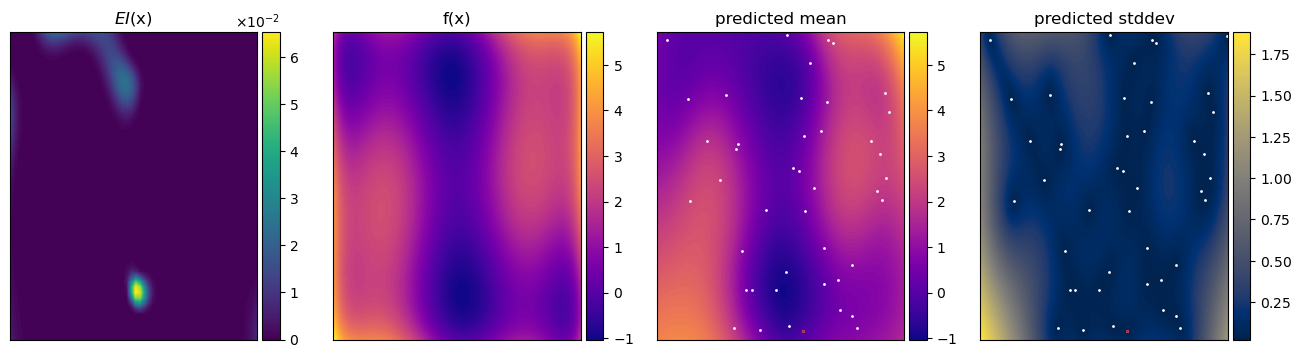

/tmp/ipykernel_13238/224669372.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


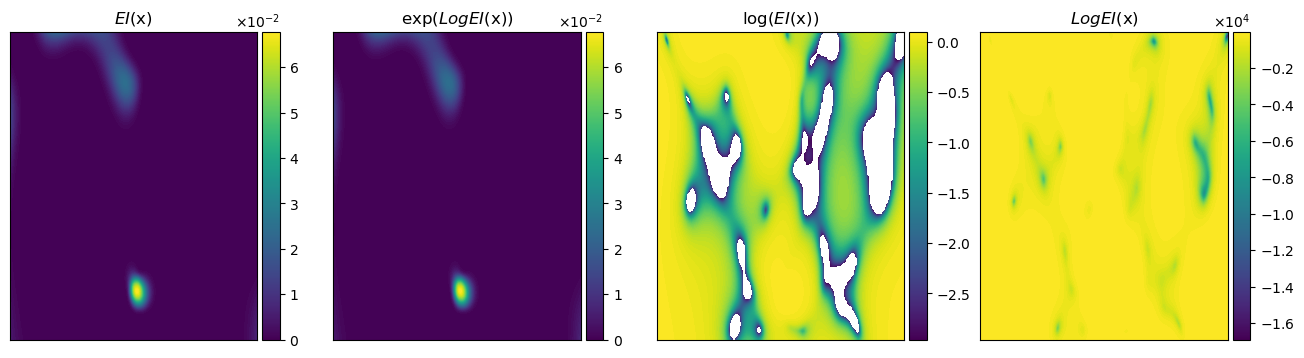

DEBUG acquisition_maximization: 0.5937061309814453


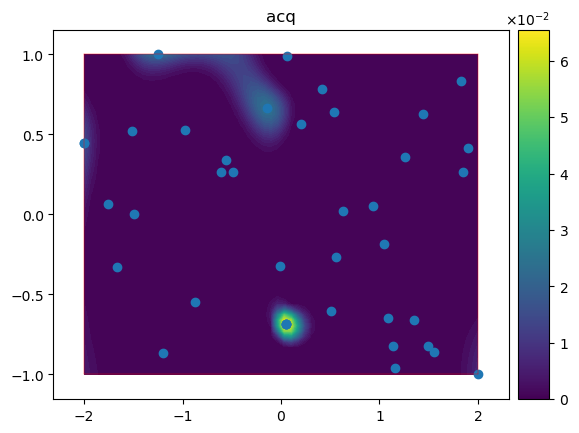

MAXIMIZE EI


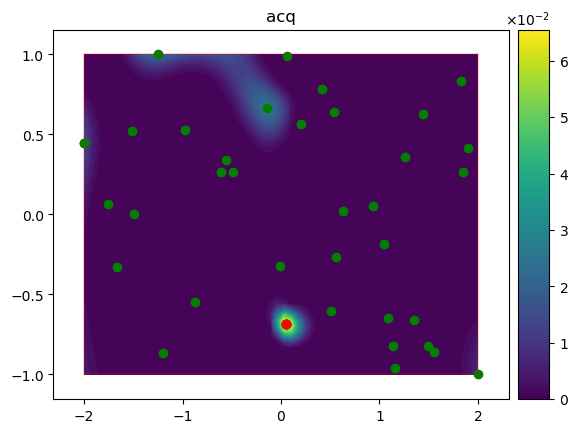

MAXIMIZE EI


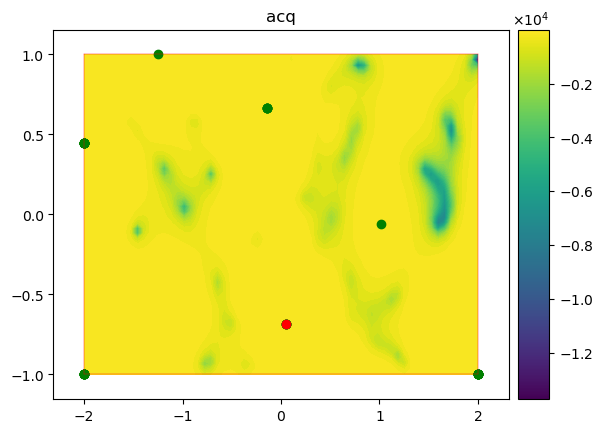

THOMPSON SAMPLING


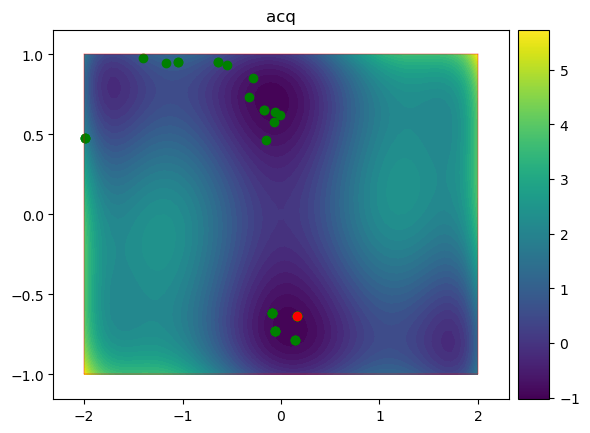

BOLTZMANN - NAIVE LOG EI
DEBUG temperature None


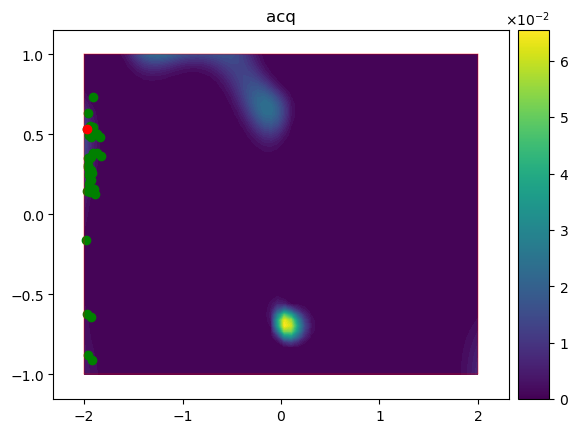

BOLTZMANN - PROPER LOG EI
DEBUG temperature None


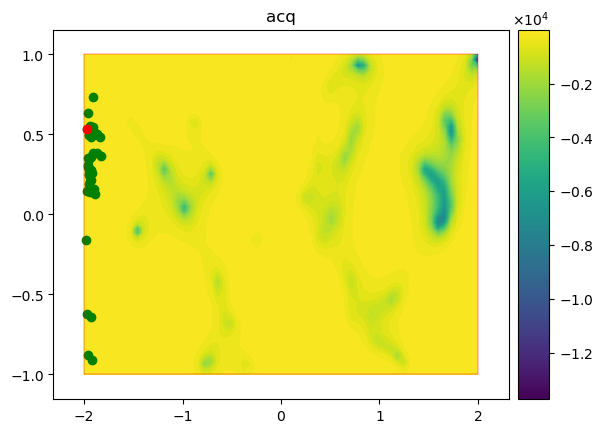

AssertionError: 

In [36]:
# Setup GP
from tinygp import GaussianProcess, kernels

def build_gp(params, x):
    kernel = jnp.exp(params["log_gp_amp"]) * kernels.Matern52(
        jnp.exp(params["log_gp_scale"]), distance=kernels.L2Distance()
    )
    return GaussianProcess(
        kernel,
        x,
        diag=1e-3,
        mean=params["gp_mean"],
    )
init_params = {
    'log_gp_amp': jnp.log(0.1),
    'log_gp_scale': jnp.log(1.0),
    'gp_mean': jnp.float64(0.0),
    #'log_gp_diag': jnp.log(0.1),
}

# Setup test samplers
from bbs.samplers import blackjax_hmc, blackjax_mala, blackjax_nuts, blackjax_cyclical_sgld, blackjax_temperedsmc, metropolis_hastings

base_config = {
    'samples_budget': 2_000,
}
adapt_params = {
    'adapt_warmup_steps': 1_500
}
do_chains = lambda n: {'num_chains': n}

# test_mala_samplers = [
#     # MALA does not deal well with multimodality and tuning step_size is quite hard since it depends on the initial state
#     ('MALA', blackjax_mala, base_config|{}),
#     ('MALAx10-_-1e-1', blackjax_mala, base_config|do_chains(10)|{'step_size': 1e-1}),
#     ('MALAx10-_-1e-2', blackjax_mala, base_config|do_chains(10)|{'step_size': 1e-2}),
#     ('MALAx10-_-1e-3', blackjax_mala, base_config|do_chains(10)|{'step_size': 1e-3}),
#     ('MALAx10-_-1e-4', blackjax_mala, base_config|do_chains(10)|{'step_size': 1e-4}),
# ]

def random_jump(key, _pos, bounds):
    return jr.uniform(key=key, minval=bounds[:,0], maxval=bounds[:,1], shape=(bounds.shape[0],))   

def get_add_normal_jump(sigma):
    def _fn(key, pos, bounds):
        return pos + sigma * jr.normal(key=key, shape=(bounds.shape[0],))   
    return _fn

def get_multiproposal(jump_funcs, weights=None):
    indices = jnp.arange(len(jump_funcs))
    def _fn(key, pos, bounds):
        key, choice_key = jr.split(key)
        i_choice = jr.choice(choice_key, indices, p=weights)
        return jax.lax.switch(i_choice, jump_funcs, key, pos, bounds)
    return _fn

def generate_multiproposal(tuples):
    list_functions = []
    list_weights = []
    for t in tuples:
        func = None
        weight = None
        if t[0] == 'random':
            _, weight = t
            func = random_jump
        elif t[0] == 'normal':
            _, weight, sigma = t
            func = get_add_normal_jump(sigma)
        else:
            print(f'Error wrong proposal distribution {t[0]}')
        list_functions.append(func)
        list_weights.append(weight)

    return get_multiproposal(list_functions, jnp.array(list_weights))
        
multi_proposal_tuples = [
    ['random', 0.25],
    ['normal', 0.25, 0.3],
    ['normal', 0.25, 0.1],
    ['normal', 0.25, 0.01],
]
multi_proposal = generate_multiproposal(multi_proposal_tuples)

test_samplers = [
    ('NUTS', blackjax_nuts, base_config|{}),
    ('NUTS 0.1', blackjax_nuts, base_config|{'inverse_mass_matrix': 0.1*jnp.array([1., 1.])}),
    ('NUTS 10', blackjax_nuts, base_config|{'inverse_mass_matrix': 10*jnp.array([1., 1.])}),
    ('MultiproposalMH', metropolis_hastings, base_config|{'proposal_distribution': multi_proposal})
    # ('adapt NUTS', blackjax_nuts, base_config|adapt_params),
    #('HMC', blackjax_hmc, base_config|{}),
    # ('HMCx4', blackjax_hmc, base_config|do_chains(4)|{}),
    # ('NUTSx4', blackjax_nuts, base_config|do_chains(4)|{}),
    # ('adapt HMC', blackjax_hmc, base_config|adapt_params),
    # ('TemperedSMC', blackjax_temperedsmc, base_config|do_chains(10)|{}),
    # ('CyclicalSGLD', blackjax_cyclical_sgld, base_config|{
    #     'step_size': 1e-3,
    # }),
    #('MultiproposalMH', metropolis_hastings, base_config|{'proposal_distribution': multi_proposal}|do_chains(4))
]

# base_config = {'samples_budget': 50_000}
# test_samplers += [
#     ('1 CyclicalSGLD', blackjax_cyclical_sgld, base_config|{
#         'step_size': 1e-3,
#     }),
#     ('3 CyclicalSGLD', blackjax_cyclical_sgld, base_config|{
#         'sgd_grad_clipping': 1.0,
#         'sgd_learning_rate': 1.0,
#         'step_size': 1e-3,
#     }),
#     ('4 CyclicalSGLD', blackjax_cyclical_sgld, base_config|{
#         'sgd_grad_clipping': 1.0,
#         'sgd_learning_rate': 1e-1,
#         'step_size': 1e-3,
#     }),
#     ('5 CyclicalSGLD', blackjax_cyclical_sgld, base_config|{
#         'sgd_grad_clipping': 1.0,
#         'sgd_learning_rate': 1e-2,
#         'step_size': 1e-3,
#     }),
# ]

problem = get_problem('sixhumpcamel', normalize_x=False)

test_methods = True
simple_example_bo_params = {'num_steps': 1, 'seed': 123, 'init_points': 10,}
bad_start_bo_params = {'num_steps': 1, 'seed': 123, 'init_points': 25,} 
bo_params = bad_start_bo_params

if True: # Plotting the figure for innaccuracies
    bo_params = {'num_steps': 1, 'seed': 3663, 'init_points': 45,} 
    test_samplers = []

if False: # Plotting the figure that shows the multimodality
    random_seed = 358 #np.random.randint(0, 500); print('used seed ', random_seed)
    bo_params = {'num_steps': 8, 'seed': random_seed, 'init_points': 15,} 
    problem = get_problem('goldstein', normalize_x=True)
    test_samplers = []
    test_methods = False

# Setup problem and BO
run_bo_with_sampler_evaluations(problem.f, problem.bounds, init_params, build_gp, samplers=test_samplers, test_methods=test_methods, **bo_params)

assert(False)

In [ ]:
from typing import Sequence
from bbs.experiment_runner import run_repeat_experiment, plot_optimization, plot_field, task_run_experiment, get_args_run_repeat_experiment
from bbs.criteria import get_ei_fn, get_log_ei_fn

# Setup GP
from tinygp import GaussianProcess, kernels

def build_gp(params, x):
    kernel = jnp.exp(params["log_gp_amp"]) * kernels.Matern52(
        jnp.exp(params["log_gp_scale"]), distance=kernels.L2Distance()
    )
    return GaussianProcess(
        kernel,
        x,
        diag=1e-3,
        mean=params["gp_mean"],
    )
init_params = {
    'log_gp_amp': jnp.log(0.1),
    'log_gp_scale': jnp.log(1.0),
    'gp_mean': jnp.float64(0.0),
    #'log_gp_diag': jnp.log(0.1),
}

bo_config = dict(
    init_model_params=init_params, 
    build_model=build_gp,
    train_model=train_gp_params,
    num_init_points=6
)
experiment_args = {
    'config_bo': bo_config, 'num_bo_steps': 30, 'num_trials': 1, 'seed': 0
}

# Selections
def max_ei(selection_key, predict_fn, posterior_sample_fn, bounds, x, y):
    x_query, _ = select_with_ei_maximization(selection_key, get_ei_fn(predict_fn, y), bounds, num_retrials=40, num_iters=3_000)
    return x_query

def sample_thompson(selection_key, predict_fn, posterior_sample_fn, bounds, x, y):
    x_query, _ = select_with_thompson_sampling(selection_key, posterior_sample_fn, bounds, num_queries=1, num_points=5_000)
    return x_query

def sample_boltzmann(selection_key, predict_fn, posterior_sample_fn, bounds, x, y):
    crit_fn = get_ei_fn(predict_fn, y)
    log_crit_fn = lambda x: jnp.log(crit_fn(x))
    x_query, _ = select_with_boltzmann_sampling(selection_key, log_crit_fn, bounds, num_queries=1, chain_length=2_000)
    return x_query

def sample_boltzmann_log_ei(selection_key, predict_fn, posterior_sample_fn, bounds, x, y):
    log_ei_fn = get_log_ei_fn(predict_fn, y)
    x_query, _ = select_with_boltzmann_sampling(selection_key, log_ei_fn, bounds, num_queries=1, chain_length=2_000, jax_compile=True)
    return x_query

def sample_boltzmann_log_ei_no_compile(selection_key, predict_fn, posterior_sample_fn, bounds, x, y):
    log_ei_fn = get_log_ei_fn(predict_fn, y)
    x_query, _ = select_with_boltzmann_sampling(selection_key, log_ei_fn, bounds, num_queries=1, chain_length=2_000, jax_compile=False)
    return x_query


#select_methods = [max_ei, sample_thompson, sample_boltzmann, sample_boltzmann_log_ei]
#select_names = ['max_ei', 'sample_thompson', 'sample_boltzmann', 'sample_boltzmann_log_ei']
# plot_options = [{
#     'label': 'max EI', 'color':'k',
# },{
#     'label': 'Thompson', 'color':'g',
# },{
#     'label': 'Boltzmann', 'color':'b',
# }]

select_methods = [sample_boltzmann_log_ei, sample_boltzmann_log_ei_no_compile]
select_names = ['sample_boltzmann_log_ei', 'sample_boltzmann_log_ei_no_compile']
plot_options = [{
    'label': 'Compile', 'color':'k',
},{
    'label': 'No compile', 'color':'g',
}]

list_problem_names = [
    #'forrester',
    'rosenbrock',
    # 'beale',
    # 'dropwave',
    # 'cosines',
    # 'branin',
    # 'goldstein',
    # 'sixhumpcamel',
    # 'mccormick',
    # 'powers',
]
list_problem_args = [{} for _ in list_problem_names]

work_tasks = []
for p_name, p_args in zip(list_problem_names, list_problem_args):
    for select_fn, select_name in zip(select_methods, select_names):
        work_identifier = (p_name, select_name)

        arg_list = get_args_run_repeat_experiment(work_identifier=work_identifier, problem_name=p_name, problem_args=p_args, **experiment_args|{'selection_fn': select_fn})
        work_tasks += arg_list

from multiprocessing import Pool
from functools import reduce
import pprint
import traceback

pp = pprint.PrettyPrinter(depth=4)
pp.pprint(work_tasks)

# Run the tasks
res_list = []
num_cores = multiprocessing.cpu_count()

for i in tqdm.trange(len(work_tasks)):
    try:
        task_run_experiment(work_tasks[i])
    except KeyboardInterrupt as e:
        raise e
    except:
        print(f'Task {i} failed!')
        pp.pprint(work_tasks[i])
        traceback.print_exc()
#with Pool(num_cores) as pool:
#    res_list = pool.map(task_run_experiment, tuple(work_tasks))

In [ ]:
%debug

In [ ]:
# Recover the results
from run_experiments import stacked_results


def get_path(d: dict, path: Sequence[str]):
    return reduce(lambda d, key: d[key], path, d)
def touch_path(d: dict, path: Sequence[str], leaf_default={}):
    for i, key in enumerate(path):
        if i == len(path) - 1:
            d = d.setdefault(key, leaf_default)
        else:
            d = d.setdefault(key, {})

def add_value(d, path, value):
    curr = d
    for key in path:
        if key not in curr:
            curr[key] = {}
        curr = curr[key]
    k, v = value
    curr[k] = v
    return d
    
def collapse_worker_results(results):
    data = {}
    for keys, res in results:
        touch_path(data, keys)
        get_path

data = {}
for keys, res in res_list:
    touch_path(data, keys, leaf_default=[])
    arr = get_path(data, keys)
    arr.append(res)
    

for problem in list_problem_names:
    all_results = []
    for method in select_names:
        all_results.append(stacked_results(data[problem][method]))

    f, ax = plt.subplots(1,1,)
    plot_optimization(ax, all_results, experiments_plot_options=plot_options)
    # f, ax = plt.subplots(1,1,)
    # plot_field(ax, 'fit_time', all_results, experiments_plot_options=plot_options)
    # f, ax = plt.subplots(1,1,)
    # plot_field(ax, 'select_time', all_results, experiments_plot_options=plot_options)
    plt.show()

In [ ]:

f, ax = plt.subplots(1,1,)
plot_optimization(ax, all_results, experiments_plot_options=plot_options)
f, ax = plt.subplots(1,1,)
plot_field(ax, 'fit_time', all_results, experiments_plot_options=plot_options)
f, ax = plt.subplots(1,1,)
plot_field(ax, 'select_time', all_results, experiments_plot_options=plot_options)

In [ ]:
%debug

In [ ]:
# OLD


def _old_run_bo_with_sampler_evaluations(f, bounds, gp_params, build_gp, num_steps=10, init_points=10, criteria=expected_improvement, samplers=[], 
        seed = 123, count_crit_calls=False):
    key = jr.PRNGKey(seed)
    key, subkey = jr.split(key)
    x = jr.uniform(key=subkey, minval=bounds[:,0], maxval=bounds[:,1], shape=(init_points, len(bounds[0])))
    y = f(x).reshape(-1)

    soft_bounds_fn = lambda x: soft_bounds_weighting(x, bounds, min_val=1e-20) # min value is non-zero to avoid zero weights

    for step in range(num_steps):
        print(f'STEP {step}')

        key, k1 = jax.random.split(key)

        # Update gp params
        gp_params, loss_val = train_gp_params(gp_params, x, y, build_gp, return_final_loss=True)
        print(f'GP parameters final loss: {loss_val}')

        def count_call():
            global global_crit_counter
            global_crit_counter += 1

        def crit_func(xtest):
            return jnp.exp(log_crit_func(xtest))
        def log_crit_func(x_in):
            if count_crit_calls:
                jax.debug.callback(count_call)

            xtest = jnp.atleast_2d(x_in)
            mu, var = build_gp(gp_params, x).predict(y, xtest, return_var=True)
            log_value = jnp.log(criteria(mu, var, y)) + jnp.log(soft_bounds_fn(xtest))
            if len(x_in.shape) == 1: # If input was 1D (just the point x) return float value directly. Required by grad methods and samplers
                log_value = log_value[0]
            return log_value

        def predict_func(xtest):
            mu, var = build_gp(gp_params, x).predict(y, xtest, return_var=True)
            return mu, var

        plot_f(f, bounds, x, y, predict_func, crit_func)
        plt.show()

        for sampler_tuple in samplers:
            global global_crit_counter
            global_crit_counter = 0
            name, sampler_run, sampler_config = sampler_tuple
            print(f'SAMPLER {name} ', sampler_config)
            _, all_samples, acceptance_rates = sampler_run(k1, log_crit_func, bounds, sampler_config, show_progress_bar=True)
            print('shape of mcmc chain', all_samples.shape)
            
            #if len(all_samples) > 2: # Avoid index access if sampler failed
            #    print(f'DEBUG SAMPLERS CHAIN. at i=0: {all_samples[0]}, at i=1: {all_samples[1]}, at i=-1: {all_samples[-1]}')
            if count_crit_calls:
                print(f'Number of crit calls {global_crit_counter}')
            # Plotting 
            if len(all_samples) > 0:
                if len(all_samples.shape) == 2: # Single chain
                    plot_chain(x, y, bounds, all_samples, crit_func, None, log_crit_func(all_samples))
                else:
                    plot_chain(x, y, bounds, all_samples.reshape(-1, bounds.shape[0]), crit_func, None, log_crit_func(all_samples[-1]))
                    for i in range(all_samples.shape[0]):
                        chain = all_samples[i]
                        plot_chain(x, y, bounds, chain, crit_func, [], log_crit_func(chain), show_second_row=False)

        
        # Get candidate and evaluate next point
        key, k1 = jax.random.split(key)
        xnext, all_samples = sample_next(k1, criteria, bounds, x, y, gp_params, build_gp)
        x = jnp.vstack((x, xnext))
        y = jnp.concatenate((y, f(xnext).reshape(-1)))  

